# IPTWSurivialEstimator Tutorial

**IPTWSurvivalEstimator is a Python package for calculating inverse probability of treatment weights (IPTW) and performing survival analysis. In this notebook, we’ll walk through how to use the package to:**

* **Compute IPTW for a dataset**
* **Visualize propensity score distributions**
* **Assess covariate balance using standardized mean differences (SMD), both before and after weighting**
* **Plot Kaplan-Meier survival curves with bootstrapped 95% confidence intervals**
* **Calculate survival metrics, including median survival and restricted mean survival time (RMST), with bootstrapped 95% confidence intervals**

In [1]:
# Tutorial setup only 
# These lines are only needed when running this notebook from the example folder in the repository
import sys
import os
sys.path.append(os.path.abspath(os.path.join(os.getcwd(), '..')))

In [2]:
from iptw_survival import IPTWSurvivalEstimator

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from lifelines.plotting import add_at_risk_counts

## Import data

In [3]:
dtype_map = pd.read_csv('../data/tutorial_df_dtypes.csv', index_col = 0).iloc[:, 0].to_dict()
df = pd.read_csv('../data/tutorial_df.csv', dtype = dtype_map)

In [4]:
df.head(3)

,PatientID,event,duration,treatment,Surgery,GroupStage_mod,days_diagnosis_to_adv,Gender,age,Race_mod,...,percent_change_weight,albumin,creatinine,total_bilirubin,opioid,van_walraven_score,commercial,medicaid,medicare,ses_mod
0,F6E944C1709E6,1,307.0,1,0,unknown,1267.0,M,68,Other Race,...,4.320203,38.0,1.20,0.5,0,-2,1,0,1,2-4
1,F75087BE5F959,1,827.0,1,1,unknown,781.0,M,83,White,...,0.344828,33.0,1.68,0.4,0,<NA>,1,0,1,1 - Lowest SES
2,FC0B515A8EBD0,1,184.0,1,0,unknown,862.0,M,84,White,...,-2.113821,NaN,NaN,NaN,0,13,1,0,1,2-4


In [5]:
df.shape

(4760, 23)

In [6]:
df.dtypes

PatientID                  object
event                       int64
duration                  float64
treatment                   int64
Surgery                     Int64
GroupStage_mod           category
days_diagnosis_to_adv     float64
Gender                   category
age                         Int64
Race_mod                 category
PDL1_status              category
ecog_index               category
weight_index              float64
percent_change_weight     float64
albumin                   float64
creatinine                float64
total_bilirubin           float64
opioid                      Int64
van_walraven_score          Int64
commercial                  int64
medicaid                    int64
medicare                    int64
ses_mod                  category
dtype: object

**For this tutorial, we’ll use the Flatiron Health advanced urothelial cancer dataset. The data has already been cleaned. Patients in this cohort have advanced urothelial cancer and are receiving first-line treatment with either pembrolizumab (treatment = 1) or gemcitabine plus carboplatin or cisplatin (treatment = 0). The event of interest is all-cause mortality (event = 1), and patients without a recorded date of death are considered censored (event = 0). The duration variable reflects the number of days from initiation of first-line treatment to death or censoring.**

**This dataset mirrors the population studied in KEYNOTE-361, a Phase III trial that evaluated these therapies but did not demonstrate a survival benefit of checkpoint inhibitor over chemotherapy. In this tutorial, we’ll use IPTWSurvivalEstimator to perform a landmark analysis to explore whether first-line pembrolizumab is associated with a survival advantage over chemotherapy in those that survive at least 90 days.**

## 1. Calculating IPTW

In [7]:
estimator = IPTWSurvivalEstimator()

In [8]:
# We apply stabilized IPTW and clip propensity scores to the [0.01, 0.99] range to reduce the influence of extreme values
estimator.fit(df = df,
              treatment_col = 'treatment',
              cat_var = ['GroupStage_mod', 'ecog_index', 'ses_mod', 'PDL1_status'],
              cont_var = ['days_diagnosis_to_adv', 'age', 'weight_index', 'percent_change_weight', 'albumin', 'creatinine', 'total_bilirubin', 'van_walraven_score'],
              binary_var = ['Surgery', 'opioid', 'commercial', 'medicaid'],
              lr_kwargs = {
                  'class_weight': 'balanced',
                  'solver': 'lbfgs',
                  'penalty': 'l2',
                  'max_iter': 1000,
                  'random_state': 42
              },
              clip_bounds = (0.01, 0.99),
              stabilized = True,
              use_missing_flags = True)

In [9]:
# To see the propensity scores after fit:
estimator.propensity_scores_['propensity_score'].head(5)

0    0.730451
1    0.615697
2    0.926436
3    0.775123
4    0.777477
Name: propensity_score, dtype: float64

In [10]:
iptw_df = estimator.transform()

In [11]:
iptw_df.head(3)

,PatientID,event,duration,treatment,Surgery,GroupStage_mod,days_diagnosis_to_adv,Gender,age,Race_mod,...,medicare,ses_mod,weight_index_missing,percent_change_weight_missing,albumin_missing,creatinine_missing,total_bilirubin_missing,van_walraven_score_missing,propensity_score,iptw
0,F6E944C1709E6,1,307.0,1,0,unknown,1267.0,M,68,Other Race,...,1,2-4,0,0,0,0,0,0,0.730451,0.299401
1,F75087BE5F959,1,827.0,1,1,unknown,781.0,M,83,White,...,1,1 - Lowest SES,0,0,0,0,0,1,0.615697,0.355203
2,FC0B515A8EBD0,1,184.0,1,0,unknown,862.0,M,84,White,...,1,2-4,0,0,1,1,1,0,0.926436,0.236063


## 2. Assess the Qualty of the IPTW Calculations
**After estimating the IPTWs, it’s importtant to evaluate how well they balance the treatment groups. In this section, we’ll:**
* **Visualize the distribution of propensity scores by treatment group to check for sufficient overlap.**
* **Assess covariate balance before and after weighting using standardized mean differences (SMDs).**

**These steps help verify that the IPTW adjustment has reduced confounding and made the treatment groups more comparable.**

### Propensity Score Plot

In [12]:
ps_fig = estimator.propensity_score_plot(bins = 30)

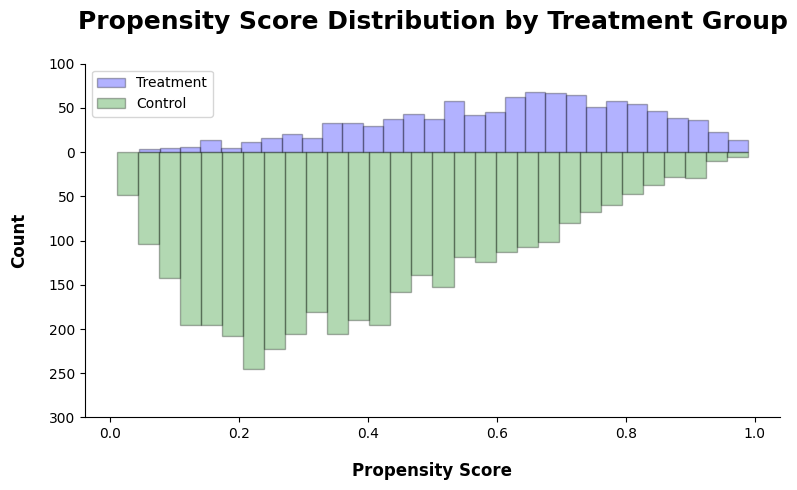

In [13]:
ps_fig

**The plot shows good overlap in the central range of propensity scores (0.25-0.85), suggesting the positivity assumption is largely met. However, a small number of patients with extreme scores may require careful attention when interpreting weighted analyses.**

### SMD Plot

In [14]:
smd_df, smd_fig = estimator.standardized_mean_differences(return_fig = True)

In [15]:
smd_df.head(5)

,variable,smd_unweighted,smd_weighted
0,total_bilirubin,0.001172,0.000697
1,total_bilirubin_missing,0.004071,0.005080
2,ses_mod__2-4,0.013255,0.003741
3,opioid,0.015398,0.027635
4,percent_change_weight,0.027129,0.019105


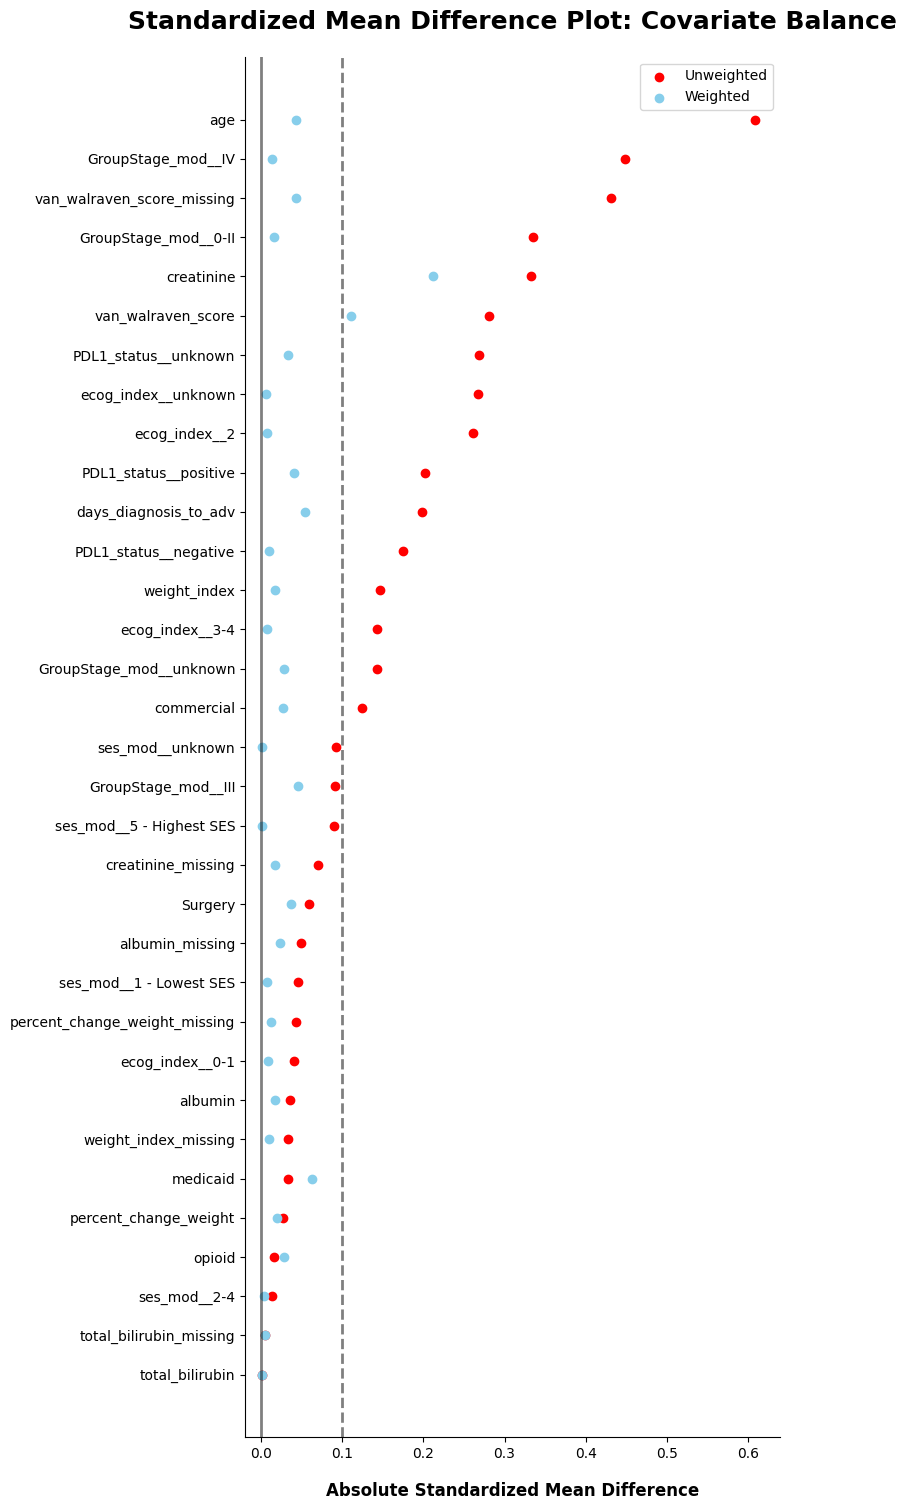

In [16]:
smd_fig

**All covariates achieved adequate balance after weighting (SMD < 0.1), except creatinine (SMD = 0.22). This residual imbalance may reflect non-overlap in renal function between the treatment groups and should be considered when interpreting results. For now, we’ve retained creatinine in the IPTW model, though transforming it (e.g., log transformation) or binning it into clinically meaningful categories (e.g., <2 vs ≥2 mg/dL) may improve balance in future analyses.**

## 3. Plot Kaplan-Meier Curves with Bootstrapped 95% Confidence Intervals (CIs)
**After calculating IPTW and assessing covariate balance, we’ll now plot IPTW-adjusted Kaplan-Meier curves for patients receiving checkpoint inhibitors versus chemotherapy.**

**Standard variance estimates for survival curves can be biased when using IPTW, potentially leading to inaccurate confidence intervals. To address this, the km_confidence_interval method uses bootstrapping: it samples the dataset with replacement, recalculates IPTW for each sample, and estimates the confidence intervals across bootstrap iterations. The resulting output can be used to plot Kaplan-Meier curves with robust, bootstrapped 95% CIs.**

In [17]:
# Convert days to month
iptw_df['duration'] = iptw_df['duration']/30

In [18]:
km_confidence_intervals_df = estimator.km_confidence_intervals(df = iptw_df,
                                                               duration_col = 'duration',
                                                               event_col = 'event',
                                                               weight_col = 'iptw',
                                                               n_bootstrap = 1000,
                                                               random_state = 42, 
                                                               n_jobs = -1)

In [19]:
km_confidence_intervals_df.head(5)

,time,treatment_estimate,control_estimate,treatment_lower_ci,treatment_upper_ci,control_lower_ci,control_upper_ci
0,3.000000,0.995203,0.998793,0.991665,0.998541,0.997589,0.999801
1,3.033333,0.993922,0.996858,0.989926,0.997813,0.994336,0.998615
2,3.066667,0.990825,0.994242,0.984426,0.996198,0.989980,0.997100
3,3.100000,0.988900,0.992663,0.982074,0.995017,0.988371,0.995791
4,3.133333,0.988307,0.988946,0.981347,0.994599,0.983743,0.992890


**In our dataset, time begins at month 3 because we restricted the cohort to patients who survived at least 3 months. This design choice helps mitigate bias from early deaths, which may be more common in frailer patients who are more likely to receive pembrolizumab over chemotherapy.**

<Axes: title={'center': 'ITPW-adjusted Kaplan-Meier Curves'}, xlabel='Months After Treatment', ylabel='Overall Survival (%)'>

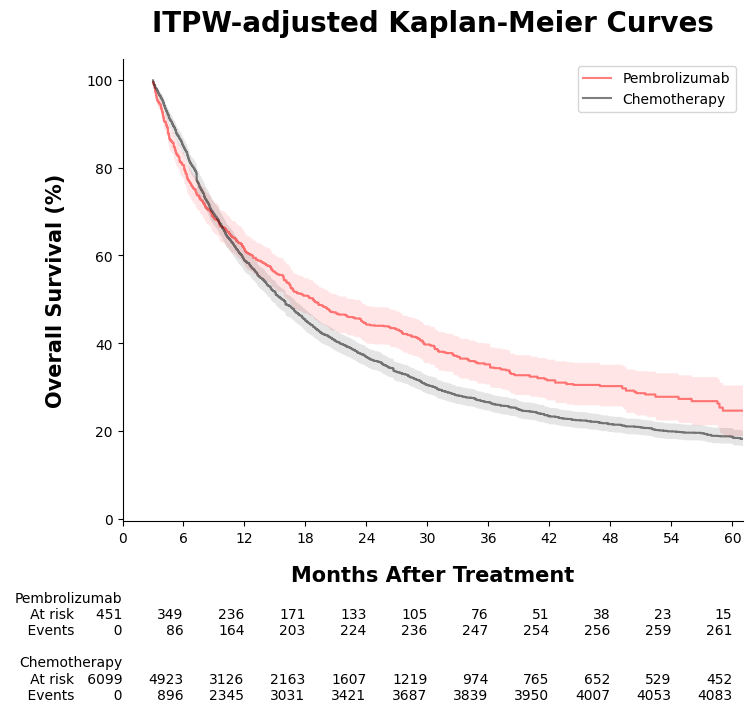

In [20]:
fig = plt.figure(figsize=(8, 6))

# Pembrolizumab arm
# Estimate
plt.step(km_confidence_intervals_df.time, 
         km_confidence_intervals_df.treatment_estimate * 100, 
         color = 'red', 
         alpha = 0.5,
         label = 'Pembrolizumab')

# 95% CI
plt.fill_between(km_confidence_intervals_df.time, 
                 km_confidence_intervals_df.treatment_lower_ci * 100, 
                 km_confidence_intervals_df.treatment_upper_ci * 100, 
                 facecolor = 'red', 
                 alpha = 0.1)

# Chemotherapy arm
# Estimate
plt.step(km_confidence_intervals_df.time, 
         km_confidence_intervals_df.control_estimate * 100, 
         color = 'black', 
         alpha = 0.5,
         label = 'Chemotherapy')

# 95% CI
plt.fill_between(km_confidence_intervals_df.time, 
                 km_confidence_intervals_df.control_lower_ci * 100, 
                 km_confidence_intervals_df.control_upper_ci * 100, 
                 facecolor = 'black', 
                 alpha = 0.1)

plt.xticks(np.arange(0, 61, 6))
plt.xlim(0, 61)

plt.title('ITPW-adjusted Kaplan-Meier Curves', size = 20, weight = 'bold',  pad = 20)
plt.ylabel('Overall Survival (%)', size = 15, weight = 'bold', labelpad = 15)
plt.xlabel('Months After Treatment', size = 15, weight = 'bold', labelpad = 15)
plt.legend(prop = {'size': 10})

plt.gca().spines['top'].set_visible(False)
plt.gca().spines['right'].set_visible(False)

add_at_risk_counts(estimator.treat_km_, 
                   estimator.control_km_, 
                   rows_to_show = ['At risk', 'Events'], 
                   labels = ['Pembrolizumab', 'Chemotherapy'])

**There appears to be a delayed treatment benefit with pembrolizumab compared to chemotherapy, with a potential survival advantage emerging beyond the two-year mark.**

## 4. Calculate Survival Metrics with Bootstrapped 95% CIs
**Next, we’ll calculate median overall survival, restricted mean survival time (RMST) at 2 and 3 years, and the probability of survival at 2 and 3 years based on the IPTW-adjusted Kaplan-Meier curves.**

**Confidence intervals are obtained via bootstrapping. For each bootstrap iteration, the IPTW is recalculated and the survival metrics are recomputed. Final estimates reflect the distribution of these bootstrapped values.**

**We do not calculate a hazard ratio, as the proportional hazards assumption is likely violated given the crossing of the Kaplan-Meier curves.**

**If you want .survival_metrics() and .km_confidence_intervals() to use identical resamples and produce aligned results, pass the same integer to the random_state for both methods. To ensure complete reproducibility, also consider passing random_state to the logistic regression model via lr_kwargs in .fit() or fit_transform() to fix propensity score estimation.**

In [21]:
results = estimator.survival_metrics(df = iptw_df,
                                     duration_col = 'duration',
                                     event_col = 'event',
                                     weight_col = 'iptw',
                                     psurv_time_points = [24, 36],
                                     rmst_time_points = [24, 36],
                                     median_time = True,
                                     n_bootstrap = 1000,
                                     random_state = 42,
                                     n_jobs = -1)

In [22]:
# Median results
print('Median Survival Results')
print(f'Pembrolizumab: {tuple(round(x, 1) for x in results['treatment']['median'])} months')
print(f'Chemotherapy: {tuple(round(x, 1) for x in results['control']['median'])} months')
print(f'Difference: {tuple(round(x, 1) for x in results['difference']['median'])} months')

Median Survival Results
Pembrolizumab: (18.8, 16.2, 22.8) months
Chemotherapy: (15.7, 14.6, 16.9) months
Difference: (3.0, 0.1, 7.3) months


In [23]:
# RMST results at 2 years
print('RMST Results at 2 Years')
print(f'Pembrolizumab: {tuple(round(x, 1) for x in results['treatment']['rmst'][24])} months')
print(f'Chemotherapy: {tuple(round(x, 1) for x in results['control']['rmst'][24])} months')
print(f'Difference: {tuple(round(x, 1) for x in results['difference']['rmst'][24])} months')

# RMST results at 3 years
print('')
print('RMST Results at 3 Years')
print(f'Pembrolizumab: {tuple(round(x, 1) for x in results['treatment']['rmst'][36])} months')
print(f'Chemotherapy: {tuple(round(x, 1) for x in results['control']['rmst'][36])} months')
print(f'Difference: {tuple(round(x, 1) for x in results['difference']['rmst'][36])} months')

RMST Results at 2 Years
Pembrolizumab: (16.0, 15.4, 16.7) months
Chemotherapy: (15.6, 15.1, 15.9) months
Difference: (0.5, -0.3, 1.3) months

RMST Results at 3 Years
Pembrolizumab: (20.8, 19.7, 21.9) months
Chemotherapy: (19.3, 18.7, 19.9) months
Difference: (1.5, 0.2, 2.9) months


In [24]:
# Probability of survival at 2 years
print('Probability of Survival at 2 Years')
print(f'Pembrolizumab: {tuple(round(x, 3) for x in results['treatment']['survival_prob'][24])}')
print(f'Chemotherapy: {tuple(round(x, 3) for x in results['control']['survival_prob'][24])}')
print(f'Difference: {tuple(round(x, 3) for x in results['difference']['survival_prob'][24])}')

# Probability of survival at 3 years
print('')
print('Probability of Survival at 3 Years')
print(f'Pembrolizumab: {tuple(round(x, 3) for x in results['treatment']['survival_prob'][36])}')
print(f'Chemotherapy: {tuple(round(x, 3) for x in results['control']['survival_prob'][36])}')
print(f'Difference: {tuple(round(x, 3) for x in results['difference']['survival_prob'][36])}')

Probability of Survival at 2 Years
Pembrolizumab: (0.442, 0.399, 0.484)
Chemotherapy: (0.369, 0.347, 0.391)
Difference: (0.074, 0.024, 0.125)

Probability of Survival at 3 Years
Pembrolizumab: (0.352, 0.306, 0.399)
Chemotherapy: (0.265, 0.246, 0.286)
Difference: (0.086, 0.039, 0.138)


**Survival outcomes favored pembrolizumab over chemotherapy across multiple metrics. These results suggest a modest but consistent survival advantage for pembrolizumab over chemotherapy in those who survive at least 90 days, especially with longer follow-up, in this real-world cohort.**